In [67]:
import pandas as pd
import numpy as np
from utils.csv import create_csv_files, open_convert_csv_files
from tqdm import tqdm, tqdm_notebook

exchange_name = 'bitmex'
symbol = 'EOS/BTC'
timeframe = '1m'
start = '01/07/2019'
end = '05/07/2019'
bar_type = 'flow_imbalance_bars'

In [2]:
bars = open_convert_csv_files(exchange_name, symbol, timeframe, start, end, bar_type=bar_type)

In [3]:
def resample_null_bars(bars):
    def custom_fill(row_name):
        return lambda row: row['close'] if np.isnan(row[row_name]) else row[row_name]

    def custom_null_fill(row_name):
        return lambda row: 0 if np.isnan(row[row_name]) else row[row_name]

    bars = bars.resample('1min').last()
    bars.loc[:, 'close'] = bars.loc[:, 'close'].ffill()
    bars['open'] = bars.apply(custom_fill('open'), axis=1)
    bars['high'] = bars.apply(custom_fill('high'), axis=1)
    bars['low'] = bars.apply(custom_fill('low'), axis=1)

    if 'ofi' in bars:
        bars['ofi'] = bars.apply(custom_null_fill('ofi'), axis=1)

    if 'tfi' in bars:
        bars['tfi'] = bars.apply(custom_null_fill('tfi'), axis=1)

    if 'vfi' in bars:
        bars['vfi'] = bars.apply(custom_null_fill('vfi'), axis=1)

    if 'volume' in bars:
        bars['volume'] = bars.apply(custom_null_fill('volume'), axis=1)

    if 'returns' in bars:
        bars['returns'] = bars.apply(custom_null_fill('returns'), axis=1)

    if 'midprice_returns' in bars:
        bars['midprice_returns'] = bars.apply(
            custom_null_fill('midprice_returns'), axis=1)

    return bars

In [502]:
x = resample_null_bars(bars)
close = x.close
volatility = close.ewm(span=60).std()

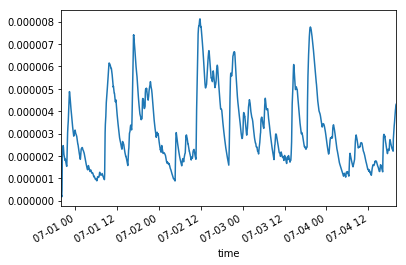

In [504]:
volatility = get_daily_volatility(close)
volatility.plot()
mean_volatility = volatility.mean()

In [525]:
def get_daily_volatility(close,time_period=60):
    return close.ewm(time_period).std()

def get_time_events(close, h):
    time_events, s_pos, s_neg = [], 0, 0
    diff = np.log(close).diff().dropna()
    for i in tqdm(diff.index[1:]):
        try:
            pos, neg = float(s_pos+diff.loc[i]), float(s_neg+diff.loc[i])
        except Exception as e:
            print(e)
            break
        s_pos, s_neg = max(0., pos), min(0., neg)
        
        if s_neg<-h:
            s_neg=0
            time_events.append(i)
        elif s_pos>h:
            s_pos=0
            time_events.append(i)
    return pd.DatetimeIndex(time_events)


def add_vertical_barrier(time_events, close, minutes=30):
    t1=close.index.searchsorted(time_events+pd.Timedelta(minutes=minutes))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=time_events[:t1.shape[0]]))
    return t1

def get_events(close,time_events,volatility,minimum_return,intervals):
    #1) compute thresholds
    threshold=volatility.loc[time_events]
    threshold=threshold[threshold>minimum_return]
            
    #2) form events object, apply stop loss on the vertical barriers
    side=pd.Series(1.,index=threshold.index)
    events=pd.concat({'intervals': intervals, 'threshold': threshold,'side': side }, axis=1).dropna(subset=['threshold'])
    df0 = apply_profit_taking_and_stop_losses(close, events)    
        
    #3) hack in order to be able to compare values
    df0['take_profit'][pd.isnull(df0['take_profit'])] = pd.Timestamp(pd.Timestamp(2100, 1, 1, 1), tz='US/Eastern')
    df0['stop_loss'][pd.isnull(df0['stop_loss'])] = pd.Timestamp(pd.Timestamp(2100, 1, 1, 1), tz='US/Eastern')
    
    events['intervals']=df0.dropna(how='all').min(axis=1)
    events = events.drop('side', axis=1)
    return events

def apply_profit_taking_and_stop_losses(close,events):
    out = events[['intervals']].copy(deep=True)
    take_profits=events['threshold']
    stop_losses=-events['threshold']
    
    for start,end in events['intervals'].fillna(close.index[-1]).iteritems():
        df0=close[start:end] # path prices
        df0=(df0/close[start]-1)*events.at[start,'side'] # path returns
        out.loc[start,'stop_loss']=df0[df0<stop_losses[start]].index.min() # earliest stop loss.
        out.loc[start,'take_profit']=df0[df0>take_profits[start]].index.min() # earliest profit taking.
        
    return out

In [528]:
horizontal_barrier_threshold = 2000 * mean_volatility
minimum_return = 1.5 * mean_volatility
time_events = getTEvents(close, h=horizontal_barrier_threshold)
intervals = addVerticalBarrier(time_events, close, minutes=30)

100%|██████████| 5755/5755 [00:01<00:00, 5363.41it/s]


In [529]:
events = getEvents(close,time_events,volatility,minimum_return,intervals=intervals)

/Users/davidvanisacker/backtest/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/davidvanisacker/backtest/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [565]:
def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['intervals'])
    px=events_.index.union(events_['intervals']).drop_duplicates()
    px=close.reindex(px,method='bfill')
    
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['returns']=px.loc[events_['intervals']].values/px.loc[events_.index]-1
    
    if 'side' in events_:
        out['returns']*=events_['side'] # meta-labeling
        
    out['bin']=np.sign(out['returns'])
    
    if 'side' in events_:
        out.loc[out['returns']<=0,'bin']=0 # meta-labeling
        
    return out

In [573]:
labels = getBins(events, close)
print(labels)

                            returns  bin
2019-06-30 22:22:00-04:00 -0.002922 -1.0
2019-07-01 09:22:00-04:00  0.000906  1.0
2019-07-01 10:14:00-04:00 -0.001617 -1.0
2019-07-01 10:56:00-04:00 -0.000894 -1.0
2019-07-01 11:00:00-04:00  0.006682  1.0
2019-07-01 11:02:00-04:00  0.000179  1.0
2019-07-01 16:30:00-04:00  0.001739  1.0
2019-07-01 16:38:00-04:00 -0.000687 -1.0
2019-07-01 16:42:00-04:00 -0.001215 -1.0
2019-07-01 16:59:00-04:00 -0.001926 -1.0
2019-07-01 17:25:00-04:00 -0.001392 -1.0
2019-07-01 17:54:00-04:00 -0.002451 -1.0
2019-07-01 20:06:00-04:00 -0.000171 -1.0
2019-07-01 21:26:00-04:00  0.000169  1.0
2019-07-02 11:00:00-04:00 -0.002616 -1.0
2019-07-02 11:34:00-04:00 -0.000176 -1.0
2019-07-02 12:01:00-04:00  0.000176  1.0
2019-07-02 13:19:00-04:00 -0.002117 -1.0
2019-07-02 13:40:00-04:00 -0.001779 -1.0
2019-07-02 14:03:00-04:00 -0.000717 -1.0
2019-07-02 14:29:00-04:00  0.000357  1.0
2019-07-02 14:59:00-04:00 -0.000180 -1.0
2019-07-02 15:20:00-04:00 -0.000181 -1.0
2019-07-02 16:05

In [574]:
labels.bin.value_counts()

-1.0    27
 1.0    15
Name: bin, dtype: int64